# (Messy) Petfinder Analysis

In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## Project Details
* **Problem**: I plan to look at a snapshot of adoptable dogs across the United States (as posted on [Petfinder.com](https://www.petfinder.com)) to determine the predominant reported breeds of dogs within the shelter and rescue systems. In particular, I want to look at this distribution state-by-state.
* **Questions**:
    - For each state (+ DC), what is the most populous reported breed found in shelters?
    - What is the current average length of stay (LOS) for dogs in each state?
    - Is the average LOS significantly different for each state?
    - For each US state (+ DC), what are the top 10 reported breeds?
* **Justification**: Examining which reported dog breeds are most often ending up homeless and offered for adoption in local shelters/rescues may help to answer questions about breed popularity and dog ownership culture in the United States (and whether there are any region-specific trends). It may also help to answer questions about how meaningful a breed identity actually is in the context of animal rescue. [This professional study](https://pubmed.ncbi.nlm.nih.gov/27008213/) determined that breed labels in dogs can influence their perceived adoptability and LOS. Hopefully, this analysis will provide some insight into how dog breed identity in shelter/rescue systems differs by region. The results could perhaps lead to further study or reinforce preexisting conclusions.
* **Datasets**: [allDogDescriptions.csv](https://github.com/the-pudding/data/tree/master/dog-shelters), a dataset of all adoptable dogs from petfinder.com on September 20th, 2019.
* **Ethical Concerns/Considerations**:
    - The results may cause people to draw false conclusions about why certain breeds often end up in shelters and rescues.
    - The results risk reinforcing biases associated with various dog breeds.
    - The results may influence rescue/shelter intake depending on the dog's perceived adoptability.

The first task is to simply read in the data.

In [143]:
df = pd.read_csv("data/allDogDescriptions.csv")

# these two 'states' appear to be either typos or somewhere in Canada, so I'll drop them
to_drop = df[ (df['contact_state'] == 'NB') | (df['contact_state'] == 'QC')].index
df.drop(to_drop, inplace = True)
df.head()

,id,org_id,url,type.x,species,breed_primary,breed_secondary,breed_mixed,breed_unknown,color_primary,color_secondary,color_tertiary,age,sex,size,coat,fixed,house_trained,declawed,special_needs,shots_current,env_children,env_dogs,env_cats,name,status,posted,contact_city,contact_state,contact_zip,contact_country,stateQ,accessed,type.y,description
0,46042150,NV163,https://www.petfinder.com/dog/harley-46042150/nv/las-vegas/animal-network-nv163/?referrer_id=87b31e7d-4508-41d1-95ff-fdb59b9d4669,Dog,Dog,American Staffordshire Terrier,Mixed Breed,True,False,White / Cream,Yellow / Tan / Blond / Fawn,NaN,Senior,Male,Medium,Short,True,True,NaN,False,True,NaN,NaN,NaN,HARLEY,adoptable,2019-09-20T16:37:59+0000,Las Vegas,NV,89147,US,89009,2019-09-20,Dog,Harley is not sure how he wound up at shelter in his senior years but as you see from the pictures the shelter asked if we could find a real home for this active senior boy. You would never know he is 9 years old. Very playful and loves humans and all the dogs he has met at adoptions he seems to like. He is 59 lbs so still pretty strong for a senior but loves walks and you have to love his ears. If you would like to meet this happy go lucky boy please contact AdoptAnimalNetwork@gmail.com. Updated pictures this Sunday.
1,46042002,NV163,https://www.petfinder.com/dog/biggie-46042002/nv/las-vegas/animal-network-nv163/?referrer_id=87b31e7d-4508-41d1-95ff-fdb59b9d4669,Dog,Dog,Pit Bull Terrier,Mixed Breed,True,False,Brown / Chocolate,White / Cream,NaN,Adult,Male,Large,Short,True,True,NaN,False,True,NaN,NaN,NaN,BIGGIE,adoptable,2019-09-20T16:24:57+0000,Las Vegas,NV,89147,US,89009,2019-09-20,Dog,"6 year old Biggie has lost his home and really wants a home of his own. We are getting more information about him, does well with other dogs if introduced properly. We know he is a big cuddle bunny but more info and pictures will be up Sunday. If you want to meet Biggie please contact AdoptAnimalNetwork@gmail.com"
2,46040898,NV99,https://www.petfinder.com/dog/ziggy-46040898/nv/mesquite/city-of-mesquite-animal-shelter-nv99/?referrer_id=87b31e7d-4508-41d1-95ff-fdb59b9d4669,Dog,Dog,Shepherd,NaN,False,False,Brindle,NaN,NaN,Adult,Male,Large,Short,True,False,NaN,False,True,NaN,NaN,NaN,Ziggy,adoptable,2019-09-20T14:10:11+0000,Mesquite,NV,89027,US,89009,2019-09-20,Dog,"Approx 2 years old.\n Did I catch your eye? I don't blame you if you had to stop and stare, I am quite cute if I do say so myself. I'm Ziggy and I think you look like a wonderful choice for my forever friend! I don't give my heart away at the drop of a hat, but if you will give me some time and space to settle in and adjust to my new life, we can be buddies. Once I'm comfortable, I love to go on walks, play, and spend time curled up with my best friends. \nZiggy is shy until he knows you and feels safe. He was found as a stray so we have no history on him. He is learning to trust, loves being petted and having belly rubs. He will follow you around the yard. He knows sit and is learning to walk on a leash. He is unsure about what toys are for but shows interest in them.\nBeautiful colors in his brindle coat. \n\n\nAdoption fee $60 (cash or check) includes neuter, rabies and DHPPC vaccination"
3,46039877,NV202,https://www.petfinder.com/dog/gypsy-46039877/nv/pahrump/pets-are-worth-saving-paws-nv202/?referrer_id=87b31e7d-4508-41d1-95ff-fdb59b9d4669,Dog,Dog,German Shepherd Dog,NaN,False,False,NaN,NaN,NaN,Baby,Female,Large,NaN,False,False,NaN,False,False,NaN,NaN,NaN,Gypsy,adoptable,2019-09-20T10:08:22+0000,Pahrump,NV,89048,US,89009,2019-09-20,Dog,NaN
4,46039306,NV184,https://www.petfinder.com/dog/theo-46039306/nv/henderson/wagging-tails-rescue-nv184/?referrer_id=87b31e7d-4508-41d1-95ff-fdb59b9d4669,Dog,Dog,Dachshund,NaN,False,False,NaN,NaN,NaN,Young,Male,Small,Long,True,False,NaN,False,True,True,True,True,Theo,adoptable,2019-09-20T06:48:30+0000,Henderson,NV,89052,US,89009,2019-09-20,Dog,"Theo is a friendly dachshund mix who gets along well with other dogs in 

I start off by getting the overall breed frequencies:

In [144]:
print("OVERALL FREQUENCIES FOR PRIMARY LISTED BREED:")
print(df['breed_primary'].value_counts())
print("\n\nOVERALL FREQUENCIES FOR SECONDARY LISTED BREED:")
print(df['breed_secondary'].value_counts())
uniq_breeds = pd.concat([df['breed_primary'], df['breed_secondary']]).drop_duplicates()
print("\n\nNUMBER OF UNIQUE DOG BREEDS: ", uniq_breeds.size)

OVERALL FREQUENCIES FOR PRIMARY LISTED BREED:
Pit Bull Terrier                            7889
Labrador Retriever                          7197
Chihuahua                                   3766
Mixed Breed                                 3242
Terrier                                     2641
Hound                                       2282
German Shepherd Dog                         2122
Boxer                                       2048
Shepherd                                    1968
American Staffordshire Terrier              1862
Beagle                                      1539
American Bulldog                            1134
Australian Cattle Dog / Blue Heeler          973
Dachshund                                    853
Border Collie                                817
Australian Shepherd                          696
Jack Russell Terrier                         637
Husky                                        564
Black Labrador Retriever                     545
Retriever              

The most common dog listed as the primary breed is the Pit Bull Terrier, closely followed by the Labrador Retriever and then by the Chihuahua. The most common secondary breed is simply "Mixed Breed", followed again by the lab and the pit bull. In total, there are 223 unique breeds posted on Petfinder.

**Question**: For each state, what is the most common breed found in shelters?

In [145]:
# some values in the original data have seemingly been shifted, which is why some "states" are actually zip codes
# I'm hoping to fix this at some point
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
df.groupby('contact_state')['breed_primary'].value_counts().groupby('contact_state').apply(lambda x : x.nlargest(10))

contact_state  contact_state  breed_primary                      
12220          12220          Basset Hound                             1
                              Beagle                                   1
                              Mixed Breed                              1
12477          12477          American Bulldog                         1
                              Mixed Breed                              1
17325          17325          Alaskan Malamute                         2
19053          19053          Pit Bull Terrier                         1
19063          19063          Pit Bull Terrier                         1
20136          20136          Maltese                                  1
20905          20905          Fox Terrier                              1
23112          23112          Labrador Retriever                       1
24588          24588          Hound                                    1
37189          37189          Yellow Labrador Retriever   

Is there really any significant difference between these groups? I realized that a Chi-Square Test wouldn't work out if the categories could differ. Maybe I can come back to this, but currently I can't think of a way to compare these groups in a way that would make sense.

**Question:** What is the current average length of stay (LOS) for dogs in each state?
<br>This refers only to pets who are still listed on Petfinder, where we "guess" the length of stay by comparing the date the dog was posted to the date the data was collected. I will take the average LOS for each U.S. state. Units are in days.

In [146]:
"""
Consumes two strings representing a date/time
Returns a list of ints containing the difference in years, months, and days respectively
"""
def subdate(date1, date2):
    # YYYY-MM-DD
    if '-' not in date2 or 'T' not in date2:
        return
    date2 = date2[0:date2.index('T')]
    date1 = pd.to_datetime(date1)
    date2 = pd.to_datetime(date2)
    return (date1 - date2).days


losDF = df.copy(deep=True)
losDF['los'] = df['posted'].apply(lambda x : subdate('2019-09-20', str(x)))
state_los = losDF.groupby('contact_state')['los'].mean().dropna()
state_los

contact_state
AK     82.600000
AL    203.932073
AR    147.164029
AZ    276.432829
CA    215.117788
CO    113.051889
CT    147.968354
DC     76.428571
DE     99.131757
FL    151.836781
GA    194.608508
HI     22.652174
IA    115.886598
ID     55.775510
IL    284.228007
IN    203.675546
KS    167.017021
KY    163.202137
LA    467.381579
MA     98.003171
MD    232.185532
ME    119.500917
MI    137.643388
MN     89.295407
MO    201.551087
MS    439.366667
MT     15.555556
NC    177.469357
ND    244.453125
NE     63.858333
NH     95.665672
NJ    201.373263
NM     86.408805
NV    302.449242
NY    234.235882
OH    175.885393
OK    313.008557
OR    124.197802
PA    187.778802
RI     69.884679
SC    237.458591
SD     73.541667
TN    197.043527
TX    219.747350
UT     95.608247
VA    204.867233
VT    116.988235
WA    108.893500
WI    100.704797
WV    230.672566
WY     70.115385
Name: los, dtype: float64

To better understand the data, let's visualize it as a bar graph.

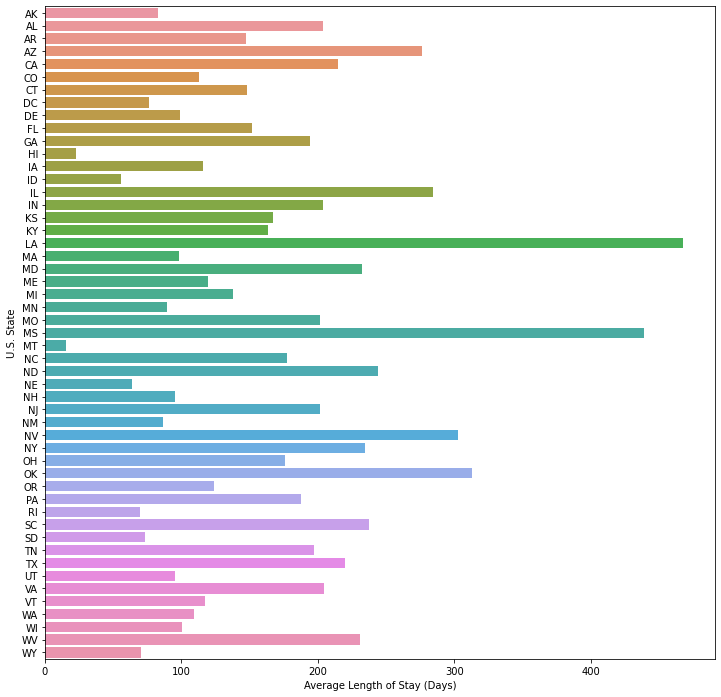

In [147]:
state_los = pd.DataFrame(state_los)
figure = plt.gcf()
figure.set_size_inches(12, 12)

sns.barplot(x = 'los', y = state_los.index, data = state_los)
plt.xlabel('Average Length of Stay (Days)')
plt.ylabel('U.S. State')
plt.show()

There are outliers, so I'd like to repeat this process using the median instead of the mean.

In [148]:
state_los_2 = losDF.groupby('contact_state')['los'].median().dropna()
state_los_2

contact_state
AK     50.0
AL     36.0
AR     42.0
AZ     43.0
CA     25.0
CO     27.0
CT     32.0
DC     19.5
DE     23.0
FL     37.0
GA     43.0
HI     10.0
IA     38.0
ID     22.0
IL     51.5
IN     37.0
KS     37.0
KY     32.0
LA     86.5
MA     24.0
MD     43.0
ME     23.0
MI     31.0
MN     23.0
MO     58.0
MS     49.5
MT     10.0
NC     33.0
ND     51.5
NE     20.0
NH     25.0
NJ     48.0
NM     26.0
NV     30.0
NY     57.0
OH     38.0
OK    126.0
OR     17.0
PA     41.0
RI     20.0
SC     38.0
SD     14.5
TN     36.0
TX     38.0
UT     44.0
VA     42.0
VT     40.0
WA     28.0
WI     17.0
WV     65.0
WY     33.5
Name: los, dtype: float64

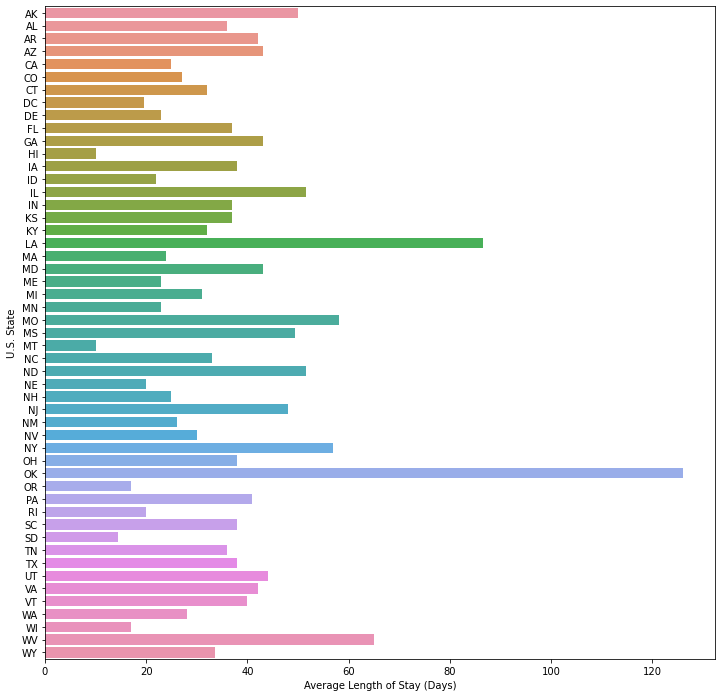

In [149]:
state_los_2 = pd.DataFrame(state_los_2)
figure = plt.gcf()
figure.set_size_inches(12, 12)

sns.barplot(x = 'los', y = state_los_2.index, data = state_los_2)
plt.xlabel('Average Length of Stay (Days)')
plt.ylabel('U.S. State')
plt.show()

Is the data normally distributed?

In [150]:
test_statistic, p_value = stats.shapiro(state_los['los'])
if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the mean LOS values are normally distributed.\n")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the mean LOS values are normally distributed.\n")

test_statistic, p_value = stats.shapiro(state_los_2['los'])
if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the median LOS values are normally distributed.")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the median LOS values are normally distributed.")

Since the pvalue is less than 0.05, we reject the null hypothesis that the mean LOS values are normally distributed.

Since the pvalue is less than 0.05, we reject the null hypothesis that the median LOS values are normally distributed.


Maybe try log transformation?

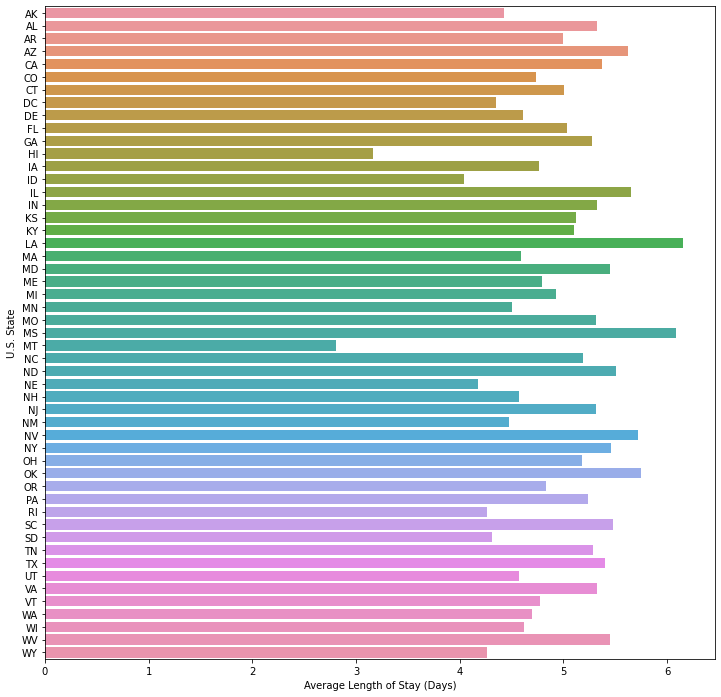

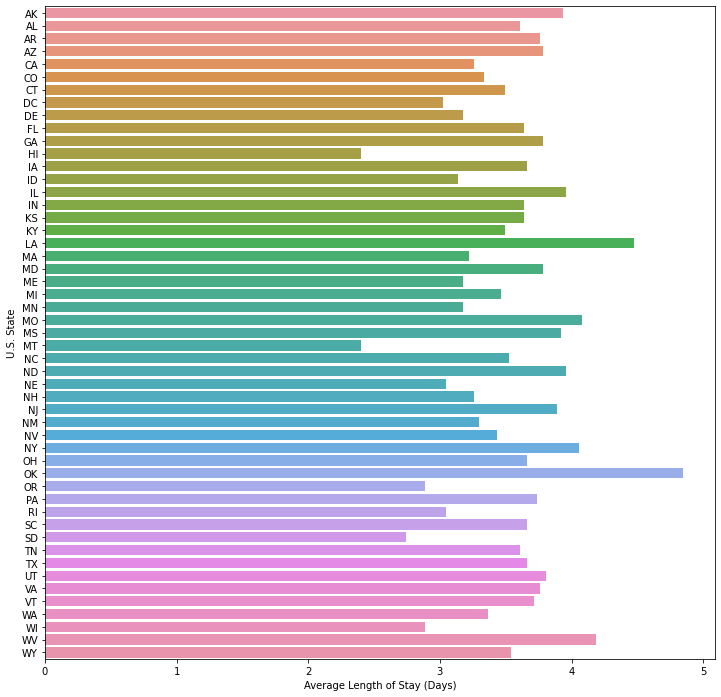

In [151]:
transformed1 = state_los['los']
transformed1 = transformed1.apply(np.log1p)
transformed2 = state_los_2['los']
transformed2 = transformed2.apply(np.log1p)

transplot1 = pd.DataFrame(transformed1)
transplot2 = pd.DataFrame(transformed2)

sns.barplot(x = 'los', y = transplot1.index, data = transplot1)
figure = plt.gcf()
figure.set_size_inches(12, 12)
plt.xlabel('Average Length of Stay (Days)')
plt.ylabel('U.S. State')
plt.show()
sns.barplot(x = 'los', y = transplot2.index, data = transplot2)
figure = plt.gcf()
figure.set_size_inches(12, 12)
plt.xlabel('Average Length of Stay (Days)')
plt.ylabel('U.S. State')
plt.show()

The first graph shown above is for the mean values, and the other is for the medians.
<br>Now, to test if they are normal.

In [152]:
test_statistic, p_value = stats.shapiro(transformed1)
if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the transformed mean LOS values are normally distributed.\n")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the transformed mean LOS values are normally distributed.\n")

test_statistic, p_value = stats.shapiro(transformed2)
if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the transformed median LOS values are normally distributed.")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the transformed median LOS values are normally distributed.")

Since the pvalue is less than 0.05, we reject the null hypothesis that the transformed mean LOS values are normally distributed.

Since the pvalue is greater than 0.05, we accept the null hypothesis that the transformed median LOS values are normally distributed.


We have determined that the data is normal when we take the median of the LOS values and then log transform them (approximately normal).

Let's perform the Krustakl-Walkkish H-test to determine if there is a statistically significant difference between medians.

In [158]:
losDF = losDF.dropna(subset=['los'])
args = losDF.groupby('contact_state')['los'].apply(pd.Series.tolist).tolist()
test_statistic, p_value = stats.kruskal(*args)

if p_value < 0.05:
    print("Since the pvalue is less than 0.05, we reject the null hypothesis that the medians are equal.")
else:
    print("Since the pvalue is greater than 0.05, we accept the null hypothesis that the medians are equal.")

Since the pvalue is less than 0.05, we reject the null hypothesis that the medians are equal.


From this, it appears that regional differences (based on median) in LOS are statistically significant. It may be worth pursuing these results further--getting to the root of why this might be, and which regions in particular differ the most.

This is the "messy" notebook. In the final notebook, I will change the questions to focus more on length of stay as opposed to breed.